In [1]:
from typing import Any

import numpy as np
import pandas as pd
import xgboost as xgb
from epinterface.geometry import compute_shading_mask
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm


In [15]:
def compute_errs(
    model: xgb.Booster,
    features: pd.DataFrame,
    targets: np.ndarray,
    target_columns: list[str],
) -> pd.DataFrame:
    """Compute model metrics for the given features and targets (per target).

    Args:
        model (xgb.Booster): The model to evaluate
        features (pd.DataFrame): The features to evaluate
        targets (np.ndarray): The targets to evaluate
        target_columns (list[str]): The target columns to evaluate
    Returns:
        err_df (pd.DataFrame): The model metrics for the given features and targets
    """
    dmat = xgb.DMatrix(features, label=targets)
    preds = model.predict(dmat)
    trues = targets
    # trues = targets[target_columns].values
    err_df = {}
    for i, col in enumerate(target_columns):
        pred_col = preds[:, i]
        true_col = trues[:, i]
        if "cooling" in col.lower():
            true_col = true_col / 2  # assume worst possible cooling cop
            pred_col = pred_col / 2  # assume worst possible cooling cop
        if "heating" in col.lower():
            true_col = true_col / 0.8  # assume worst possible heating cop
            pred_col = pred_col / 0.8  # assume worst possible heating cop
        r2 = r2_score(true_col, pred_col)
        mae = mean_absolute_error(true_col, pred_col)
        mape = mean_absolute_percentage_error(true_col, pred_col)
        mse = mean_squared_error(true_col, pred_col)
        rmse = np.sqrt(mse)
        cvrmse = rmse / true_col.mean()
        p95_error = np.percentile(np.abs(true_col - pred_col), 95)
        p95_error_normalized = p95_error / true_col.max()
        p95_error_percentage = np.percentile(np.abs(true_col - pred_col) / true_col, 95)
        err_df[col] = pd.Series({
            "mae": mae,
            "mape": mape,
            "rmse": rmse,
            "cvrmse": cvrmse,
            "r2": -r2,
            "p95": p95_error,
            "p95_norm": p95_error_normalized,
            "p95_pct": p95_error_percentage,
        })

    err_df = pd.DataFrame(err_df)
    err_df.index.name = "metric"
    err_df.columns.name = "target"
    return err_df


def check_typology(row: pd.Series) -> int:
    """Check the typology of the given row.

    Note: this is necessary because of some logic which changes
    simulation configuration but did not get added to the final index
    of the dataset and is only necessary for this notebook.

    Args:
        row (pd.Series): The row to check
    Returns:
        typology (int): The typology of the given row
    """
    if (
        (
            ("multi" in row["typology"].lower() or "mf" in row["typology"].lower())
            and "4 units" not in row["typology"].lower()
            and "3 units" not in row["typology"].lower()
        )
        or row["num_floors"] > 3
        or row["footprint_area"] > 1000
    ):
        return 0
    return 1


def generate_train_test_splits(
    specs: pd.DataFrame,
    n: int,
    test_size: float,
    strata_col: str,
    stratum_ixs: list[Any],
):
    """This function will generate the train and test indices for the given strata (or all strata).

    The basic logic is to iteratively visit each stratum, select all of its indices, then downsample to
    the number of simulations per stratum and split into train and test.  Some special attention is needed
    when the number of simulations per stratum is less than the requested number of simulations.

    Args:
        specs (pd.DataFrame): The specifications of the buildings
        n (int): The number of simulations to use
        test_size (float): The fraction of the data to use for testing
        strata_col (str): The stratum column to use for stratification
        stratum_ixs (list[Any]): The indices of the strata to use; if empty, all strata will be used
    Returns:
        train_ixs (np.ndarray): The indices of the training simulations
        test_ixs (np.ndarray): The indices of the testing simulations
        train_ixs_by_stratum (dict[str, np.ndarray]): The indices of the training simulations for each stratum within the original dataset
        test_ixs_by_stratum (dict[str, np.ndarray]): The indices of the testing simulations for each stratum within the original dataset
        train_ixs_by_stratum_renumbered (dict[str, np.ndarray]): The renumbered indices of the training simulations for each stratum within the training dataset
        test_ixs_by_stratum_renumbered (dict[str, np.ndarray]): The renumbered indices of the testing simulations for each stratum within the testing dataset
    """
    # This will assist us in selecting a stratified sample of the data
    # but will be less relevant once we have dimensionality explosion per building
    stratum_counts = specs[strata_col].value_counts()
    stratum_counts = (
        stratum_counts.iloc[stratum_ixs] if len(stratum_ixs) > 0 else stratum_counts
    )
    n_per_stratum = int(n / len(stratum_counts))

    # we want to store both the original indices (what row from the full dataset they were)
    # and the renumbered indices (which is used for training and testing so that we can
    # emulate progressive training
    train_ixs_by_stratum = {}
    test_ixs_by_stratum = {}
    train_ixs_by_stratum_renumbered = {}
    test_ixs_by_stratum_renumbered = {}
    total_train = 0
    total_test = 0

    # we will store the growing array of train and test indices from the original dataset
    # before converting to numpy arrays and selecting the rows
    train_ix = []
    test_ix = []
    for stratum in stratum_counts.index:
        # select the correct indices and then randomly split into train and test
        mask = specs[strata_col] == stratum
        ixs = np.where(mask)[0]
        if mask.sum() < n_per_stratum:
            # in this demo notebook, we need to be cognizant of the fact that the
            # number of simulations per stratum may be less than the requested stratum size
            # so we will need to do special handling for that case
            # to just split all available simulations according to the train test size
            n_train_stratum = int(len(ixs) * (1 - test_size))
            train_ixs = np.random.choice(ixs, size=n_train_stratum, replace=False)
            test_ixs = np.setdiff1d(ixs, train_ixs)
            train_ix.extend(train_ixs)
            test_ix.extend(test_ixs)
            train_ixs_by_stratum[stratum] = train_ixs
            test_ixs_by_stratum[stratum] = test_ixs
            train_ixs_by_stratum_renumbered[stratum] = (
                np.arange(len(train_ixs)) + total_train
            )
            test_ixs_by_stratum_renumbered[stratum] = (
                np.arange(len(test_ixs)) + total_test
            )
            total_train += len(train_ixs)
            total_test += len(test_ixs)
        else:
            # standard train/test splitting for the case where the number of simulations
            # per stratum is greater than the requested stratum size
            ixs = np.random.choice(
                ixs, size=min(n_per_stratum, len(ixs)), replace=False
            )
            train_ixs, test_ixs = train_test_split(
                ixs, test_size=test_size, random_state=42
            )
            train_ix.extend(train_ixs)
            test_ix.extend(test_ixs)
            train_ixs_by_stratum[stratum] = train_ixs
            test_ixs_by_stratum[stratum] = test_ixs
            train_ixs_by_stratum_renumbered[stratum] = (
                np.arange(len(train_ixs)) + total_train
            )
            test_ixs_by_stratum_renumbered[stratum] = (
                np.arange(len(test_ixs)) + total_test
            )
            total_train += len(train_ixs)
            total_test += len(test_ixs)
    train_ixs = np.array(train_ix)
    test_ixs = np.array(test_ix)
    return (
        train_ixs,
        test_ixs,
        train_ixs_by_stratum,
        test_ixs_by_stratum,
        train_ixs_by_stratum_renumbered,
        test_ixs_by_stratum_renumbered,
    )


def compute_progressive_model(
    X_train_features: pd.DataFrame,
    Y_train: pd.DataFrame,
    X_test_features: pd.DataFrame,
    Y_test: pd.DataFrame,
    target_columns: list[str],
    features_stratum_col: str,
    sample_frac_breakpoints: list[float],
    xgb_config: dict,
    num_boost_round: int,
    early_stopping_rounds: int,
    verbose_eval: bool,
    train_ixs_by_stratum_renumbered: dict[str, np.ndarray],
    test_ixs_by_stratum_renumbered: dict[str, np.ndarray],
    unique_strata: np.ndarray,
    test_size: float,
):
    unique_stratum_codes = np.arange(len(unique_strata))
    n_available_sims = X_train_features.shape[0]
    all_err_dfs = {}
    for sample_frac in tqdm(
        sample_frac_breakpoints, total=len(sample_frac_breakpoints)
    ):
        all_train_ixs = []
        all_test_ixs = []
        samps_per_stratum = int(n_available_sims / len(unique_strata) * sample_frac)
        n_train_samps = int(samps_per_stratum * (1 - test_size))
        n_test_samps = int(samps_per_stratum * test_size)
        for stratum_train_ixs in train_ixs_by_stratum_renumbered.values():
            n_samples = min(n_train_samps, len(stratum_train_ixs))
            stratum_train_ixs = stratum_train_ixs[:n_samples]
            all_train_ixs.extend(stratum_train_ixs)

        for stratum_test_ixs in test_ixs_by_stratum_renumbered.values():
            n_samples = min(n_test_samps, len(stratum_test_ixs))
            stratum_test_ixs = stratum_test_ixs[:n_samples]
            all_test_ixs.extend(stratum_test_ixs)

        X_train_features_subset = X_train_features.iloc[all_train_ixs]
        Y_train_subset = Y_train.iloc[all_train_ixs]
        X_test_features_subset = X_test_features.iloc[all_test_ixs]
        Y_test_subset = Y_test.iloc[all_test_ixs]

        train_dmatrix = xgb.DMatrix(
            X_train_features_subset, label=Y_train_subset[target_columns].values
        )
        test_dmatrix = xgb.DMatrix(
            X_test_features_subset, label=Y_test_subset[target_columns].values
        )

        model = xgb.train(
            xgb_config,
            train_dmatrix,
            num_boost_round=num_boost_round,
            evals=[(test_dmatrix, "test")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=verbose_eval,
        )

        err_dfs = {}
        for stratum_code in unique_stratum_codes:
            mask = X_test_features[features_stratum_col] == stratum_code
            err_dfs[stratum_code] = compute_errs(
                model,
                X_test_features[mask],
                Y_test[target_columns].values[mask],
                target_columns,
            )

        err_dfs = pd.concat(err_dfs, axis=1, names=[features_stratum_col]).T
        all_err_dfs[sample_frac] = err_dfs
    all_err_dfs = pd.concat(all_err_dfs, axis=0, names=["sample_frac"])
    return all_err_dfs

In [3]:
specs_path = (
    "C:/Users/szvsw/repos/bayesian-ubem/notebooks/cache/result-specs-with-neighbors.pq"
)
results_path = "C:/Users/szvsw/repos/bayesian-ubem/notebooks/cache/results.h5"

specs_df = pd.read_parquet(specs_path).sort_values(by="sort_index")
results_df = pd.read_hdf(results_path).sort_index(level="sort_index")


In [4]:
target_columns = results_df.columns.tolist()
n = 200_000  # number of simulations to use
test_size = 0.3  # fraction of data to use for testing
stratum = "epwzip_path"  # use this to stratify the data
stratum_ixs = []  # use this to only focus on certain strata

(
    train_ixs,
    test_ixs,
    train_ixs_by_stratum,
    test_ixs_by_stratum,
    train_ixs_by_stratum_renumbered,
    test_ixs_by_stratum_renumbered,
) = generate_train_test_splits(specs_df, n, test_size, stratum, stratum_ixs)


In [7]:
X_train = specs_df.iloc[train_ixs]
X_test = specs_df.iloc[test_ixs]
Y_train = results_df.iloc[train_ixs]
Y_test = results_df.iloc[test_ixs]
n_angles = 12

X_train_masks = np.array([
    compute_shading_mask(
        building=row["rotated_rectangle"],
        neighbors=row["neighbor_polys"],
        neighbor_floors=row["neighbor_floors"],
        neighbor_f2f_height=3.5,
        azimuthal_angle=2 * np.pi / n_angles,
    )
    for _ix, row in X_train.iterrows()
])

X_test_masks = np.array([
    compute_shading_mask(
        building=row["rotated_rectangle"],
        neighbors=row["neighbor_polys"],
        neighbor_floors=row["neighbor_floors"],
        neighbor_f2f_height=3.5,
        azimuthal_angle=2 * np.pi / n_angles,
    )
    for _ix, row in X_test.iterrows()
])

for i in range(X_train_masks.shape[1]):
    X_train[f"shading_mask_{i:02d}"] = X_train_masks[:, i]
    X_test[f"shading_mask_{i:02d}"] = X_test_masks[:, i]


In [9]:
feature_columns = [
    "footprint_area",
    "num_floors",
    "long_edge_angle",
    "long_edge",
    "short_edge",
    "rotated_rectangle_area_ratio",
] + [f"shading_mask_{i:02d}" for i in range(n_angles)]

# Weather file location handling
unique_epws = pd.concat([X_train["epwzip_path"], X_test["epwzip_path"]]).unique()
X_train_epw = pd.Categorical(X_train["epwzip_path"], categories=unique_epws)
X_test_epw = pd.Categorical(X_test["epwzip_path"], categories=unique_epws)
X_train_epw_onehot = pd.get_dummies(X_train_epw, prefix="epw").astype(int)
X_test_epw_onehot = pd.get_dummies(X_test_epw, prefix="epw").astype(int)
X_train_epw_onehot.index = X_train.index
X_test_epw_onehot.index = X_test.index
X_train_epw_codes = X_train_epw.codes.astype(int)
X_test_epw_codes = X_test_epw.codes.astype(int)


# typology handling
X_train_typology = X_train.apply(check_typology, axis=1)
X_test_typology = X_test.apply(check_typology, axis=1)

# Year built handling
X_train_year_bracket = pd.cut(
    X_train["year_built"], bins=[0000, 1974, 2003, 3000], labels=[0, 1, 2]
)
X_test_year_bracket = pd.cut(
    X_test["year_built"], bins=[0000, 1974, 2003, 3000], labels=[0, 1, 2]
)
X_train_year_bracket_onehot = pd.get_dummies(
    X_train_year_bracket, prefix="year_bracket"
).astype(int)
X_test_year_bracket_onehot = pd.get_dummies(
    X_test_year_bracket, prefix="year_bracket"
).astype(int)
X_train_year_bracket_codes = X_train_year_bracket.astype(int)
X_test_year_bracket_codes = X_test_year_bracket.astype(int)

# zoning handling
X_train_zoning = ((X_train["long_edge"] > 15) & (X_train["short_edge"] > 15)).astype(
    float
)
X_test_zoning = ((X_test["long_edge"] > 15) & (X_test["short_edge"] > 15)).astype(float)

# angle handling
X_train_angle = X_train["long_edge_angle"]
X_test_angle = X_test["long_edge_angle"]
X_train_angle_sin = np.sin(X_train_angle)
X_test_angle_sin = np.sin(X_test_angle)
X_train_angle_cos = np.cos(X_train_angle)
X_test_angle_cos = np.cos(X_test_angle)


# Create feature dataframes
X_train_features = pd.DataFrame({
    **X_train[feature_columns],
    **{"epw_code": X_train_epw_codes},
    **{"typology": X_train_typology},
    **{"year_bracket": X_train_year_bracket_codes},
    **{"zoning": X_train_zoning},
    **{"angle_sin": X_train_angle_sin},
    **{"angle_cos": X_train_angle_cos},
})

X_test_features = pd.DataFrame({
    **X_test[feature_columns],
    **{"epw_code": X_test_epw_codes},
    **{"typology": X_test_typology},
    **{"year_bracket": X_test_year_bracket_codes},
    **{"zoning": X_test_zoning},
    **{"angle_sin": X_test_angle_sin},
    **{"angle_cos": X_test_angle_cos},
})
X_train_features = pd.concat(
    [X_train_features, X_train_year_bracket_onehot, X_train_epw_onehot], axis=1
)
X_test_features = pd.concat(
    [X_test_features, X_test_year_bracket_onehot, X_test_epw_onehot], axis=1
)


In [10]:
xgb_config = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 5,  # 7
    "eta": 0.1,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    # "alpha": 0.01,
    # "lambda": 0.01,
    # "gamma": 0.01,
}


train_dmatrix = xgb.DMatrix(X_train_features, label=Y_train[target_columns].values)
test_dmatrix = xgb.DMatrix(X_test_features, label=Y_test[target_columns].values)

model = xgb.train(
    xgb_config,
    train_dmatrix,
    num_boost_round=2000,
    evals=[(test_dmatrix, "test")],
    early_stopping_rounds=20,
    verbose_eval=True,
)


[0]	test-rmse:33.85423
[1]	test-rmse:30.83607
[2]	test-rmse:27.99317
[3]	test-rmse:25.42135
[4]	test-rmse:23.14772
[5]	test-rmse:21.10170
[6]	test-rmse:19.28495
[7]	test-rmse:17.69283
[8]	test-rmse:16.26222
[9]	test-rmse:14.96870
[10]	test-rmse:13.83585
[11]	test-rmse:12.82479
[12]	test-rmse:11.93656
[13]	test-rmse:11.16165
[14]	test-rmse:10.47023
[15]	test-rmse:9.88175
[16]	test-rmse:9.35712
[17]	test-rmse:8.89264
[18]	test-rmse:8.48866
[19]	test-rmse:8.13500
[20]	test-rmse:7.82578
[21]	test-rmse:7.55780
[22]	test-rmse:7.30160
[23]	test-rmse:7.07668
[24]	test-rmse:6.89386
[25]	test-rmse:6.71765
[26]	test-rmse:6.56186
[27]	test-rmse:6.42782
[28]	test-rmse:6.28796
[29]	test-rmse:6.16598
[30]	test-rmse:6.03707
[31]	test-rmse:5.94052
[32]	test-rmse:5.84620
[33]	test-rmse:5.74657
[34]	test-rmse:5.66980
[35]	test-rmse:5.54407
[36]	test-rmse:5.47291
[37]	test-rmse:5.40339
[38]	test-rmse:5.33156
[39]	test-rmse:5.26229
[40]	test-rmse:5.15855
[41]	test-rmse:5.09924
[42]	test-rmse:5.03395
[43]	t

In [16]:
err_comparator = pd.Series({
    "mae": 2.0,
    "mape": 0.1,
    "rmse": 2.5,
    "cvrmse": 0.1,
    "r2": -0.9,
    "p95": 10,
    "p95_norm": 0.05,
    "p95_pct": 0.1,
})

err_comparator = pd.Series({
    "mae": 1.25,
    "mape": 0.05,
    "rmse": 1.75,
    "cvrmse": 0.05,
    "r2": -0.95,
    "p95": 5,
    "p95_norm": 0.05,
    "p95_pct": 0.1,
})

In [17]:
all_err_dfs = compute_progressive_model(
    X_train_features=X_train_features,
    Y_train=Y_train,
    X_test_features=X_test_features,
    Y_test=Y_test,
    target_columns=target_columns,
    features_stratum_col="epw_code",
    sample_frac_breakpoints=[
        0.005,
        0.01,
        0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.35,
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        1.0,
    ],
    xgb_config=xgb_config,
    num_boost_round=2000,
    early_stopping_rounds=20,
    verbose_eval=False,
    train_ixs_by_stratum_renumbered=train_ixs_by_stratum_renumbered,
    test_ixs_by_stratum_renumbered=test_ixs_by_stratum_renumbered,
    unique_strata=unique_epws,
    test_size=test_size,
)


  0%|          | 0/22 [00:00<?, ?it/s]

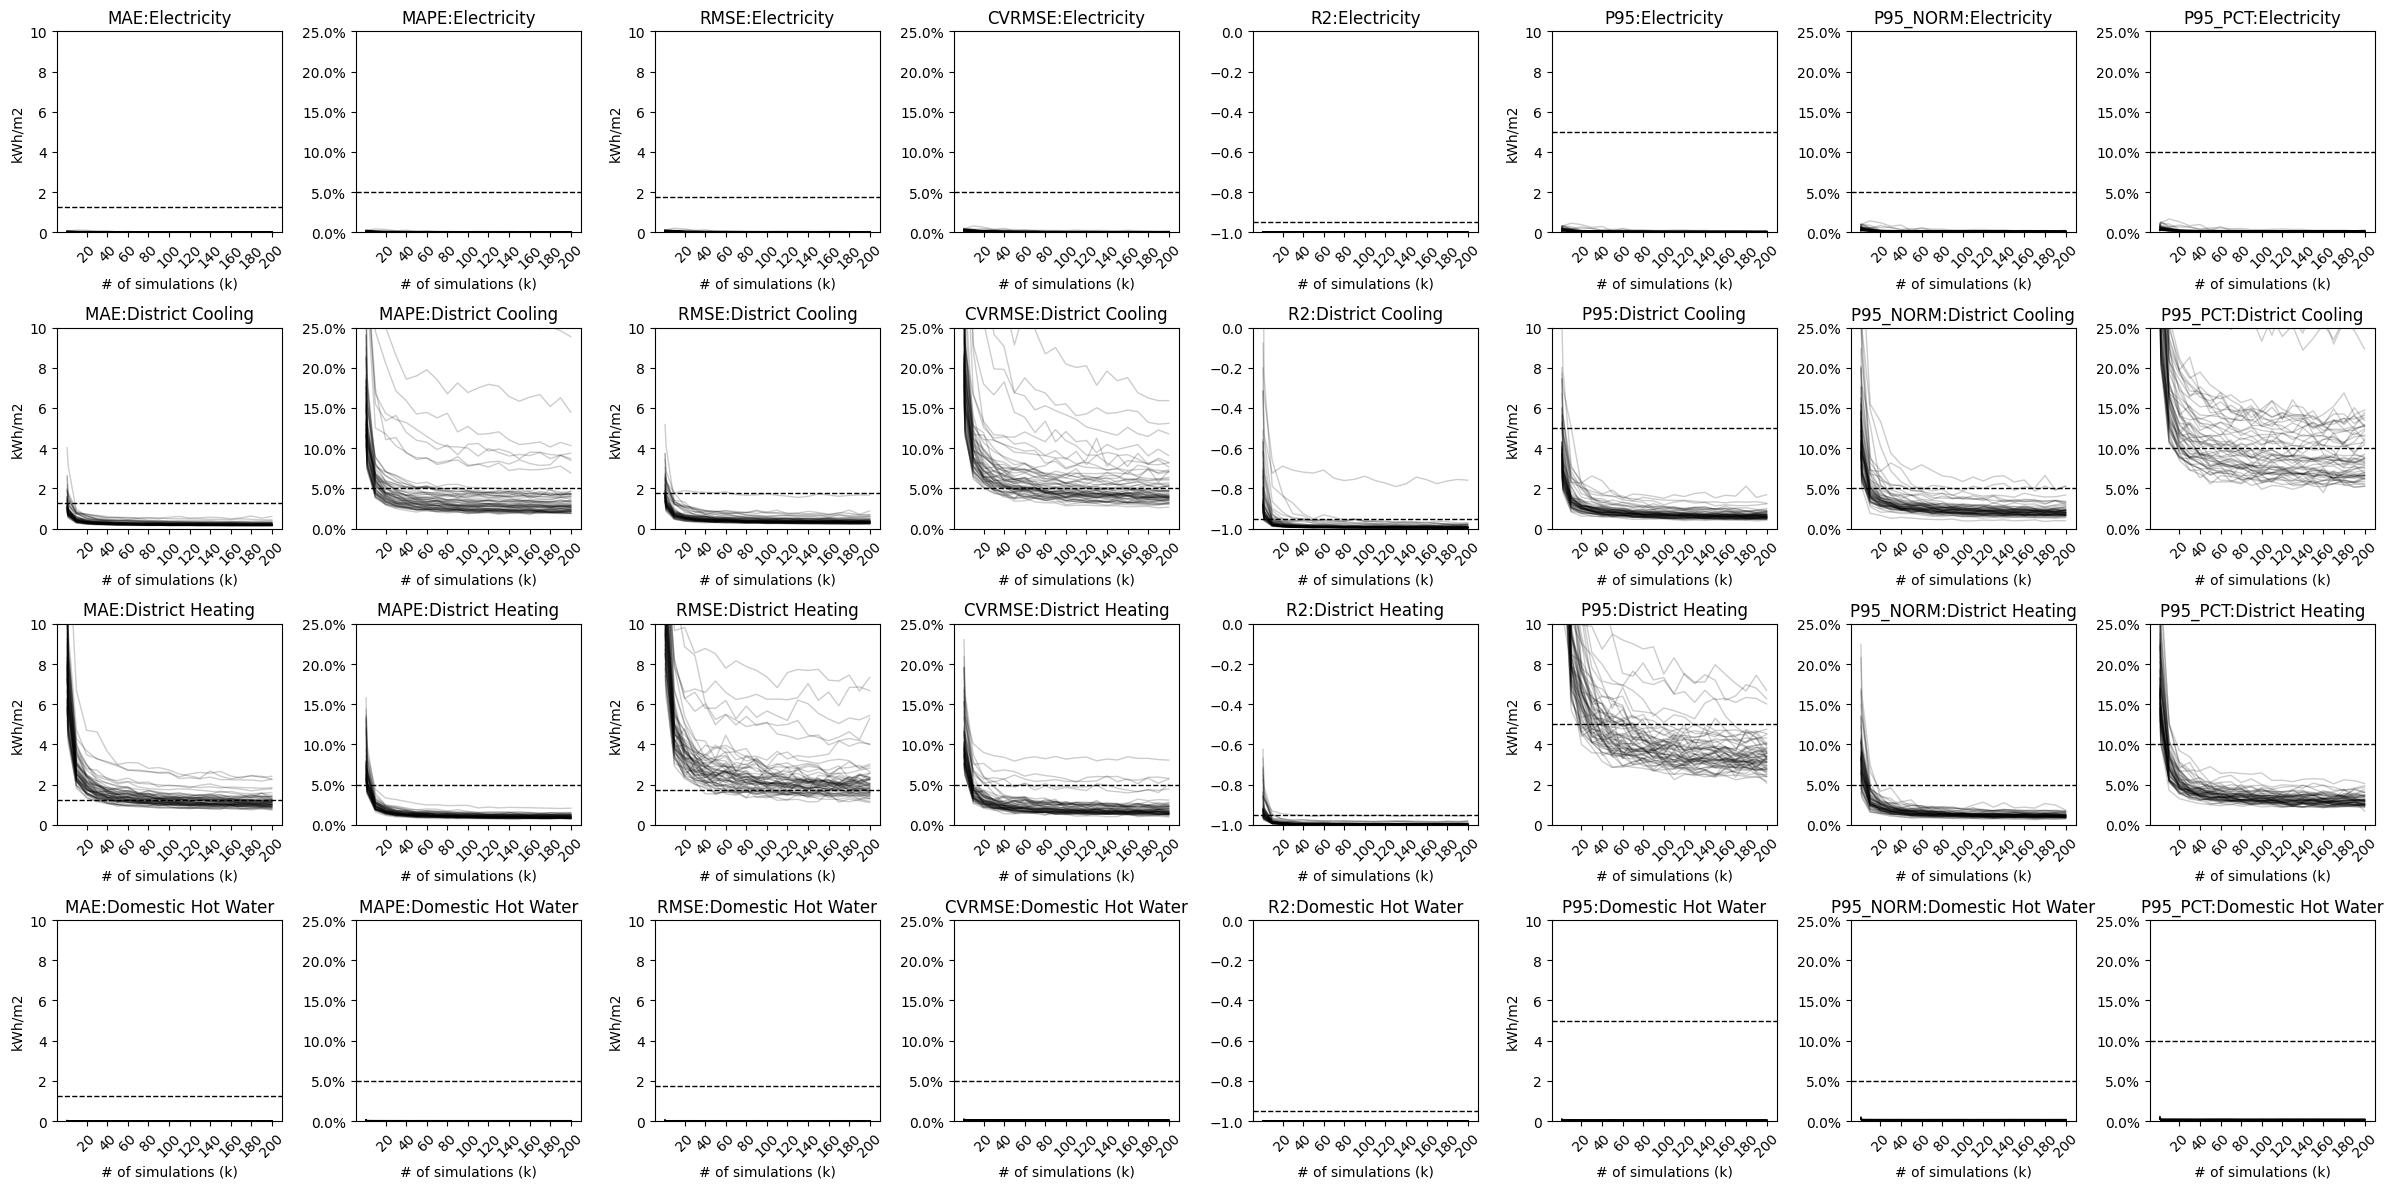

In [28]:
import matplotlib.pyplot as plt

# import the necesssary formatters for percentages
from matplotlib.ticker import PercentFormatter

axis_ylims = {
    "mae": (0, 10),
    "mape": (0, 0.25),
    "rmse": (0, 10),
    "cvrmse": (0, 0.25),
    "r2": (-1, 0),
    "p95": (0, 10),
    "p95_norm": (0, 0.25),
    "p95_pct": (0, 0.25),
}
axis_units = {
    "mae": "kWh/m2",
    "mape": "%",
    "rmse": "kWh/m2",
    "cvrmse": "%",
    "r2": "",
    "p95": "kWh/m2",
    "p95_norm": "%",
    "p95_pct": "%",
}
fig, ax = plt.subplots(
    len(target_columns),
    all_err_dfs.shape[1],
    figsize=(
        3 * all_err_dfs.shape[1],
        3 * len(target_columns),
    ),
)

for j, col in enumerate(target_columns):
    for i, metric in enumerate(all_err_dfs.columns):
        for k, epw_code in enumerate(
            all_err_dfs.index.get_level_values("epw_code").unique()
        ):
            data = all_err_dfs.loc[(slice(None), epw_code, col), metric]
            x = data.index.get_level_values("sample_frac")
            y = data.values
            # window_size = 4
            # y_rolling = np.convolve(y, np.ones(window_size) / window_size, mode="valid")
            # ax[j, i].plot(x[window_size - 1 :], y_rolling, lw=1, color="k", alpha=0.2)
            ax[j, i].plot(x, y, lw=1, color="k", alpha=0.2)

        ax[j, i].set_title(f"{metric.upper()}:{col}")
        ax[j, i].set_ylim(*axis_ylims[metric])
        if axis_units[metric] == "%":
            ax[j, i].yaxis.set_major_formatter(PercentFormatter(1))
        else:
            ax[j, i].set_ylabel(axis_units[metric])

        ax[j, i].axhline(err_comparator[metric], color="k", ls="--", lw=1)
        ax[j, i].set_xlabel("# of simulations (k)")
        x_tick_locs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        x_tick_labels = [f"{int((x_i * n) // 1000)}" for x_i in x_tick_locs]
        ax[j, i].set_xticks(x_tick_locs, x_tick_labels, rotation=45)

fig.tight_layout()


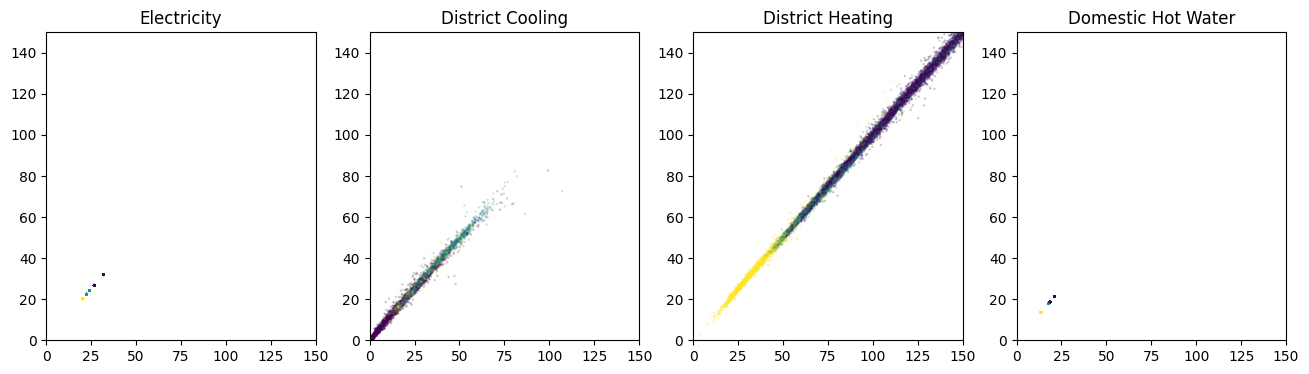

In [284]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(target_columns), figsize=(4 * len(target_columns), 4))
for epw in unique_epws:
    mask = X_test["epwzip_path"] == epw
    epw_code = X_test_features["epw_code"][mask].iloc[0]
    dmat = xgb.DMatrix(X_test_features[mask], label=Y_test[target_columns].values[mask])
    Y_preds = model.predict(dmat)
    Y_true = Y_test[target_columns].values[mask]
    X_test_features_masked = X_test_features[mask]
    colors = X_test_features_masked["year_bracket"].values
    # colors = X_test_features_masked["typology"].values
    # colors = X_test_features_masked["angle_sin"].values
    # colors = X_test_features_masked["angle_cos"].values
    # colors = X_test_features_masked["year_built"].values
    for i, col in enumerate(target_columns):
        ax[i].scatter(Y_true[:, i], Y_preds[:, i], alpha=0.2, s=0.5, c=colors)
        ax[i].set_title(col)
        ax[i].set_xlim(0, 150)
        ax[i].set_ylim(0, 150)


In [29]:
err_df = compute_errs(
    model, X_test_features, Y_test[target_columns].values, target_columns
)
err_df.round(2).T

metric,mae,mape,rmse,cvrmse,r2,p95,p95_norm,p95_pct
target,,,,,,,,
Electricity,0.01,0.00,0.02,0.00,-1.00,0.03,0.00,0.00
District Cooling,0.20,0.04,0.42,0.06,-0.99,0.65,0.01,0.13
District Heating,1.13,0.01,2.79,0.02,-1.00,3.33,0.01,0.03
Domestic Hot Water,0.01,0.00,0.01,0.00,-1.00,0.03,0.00,0.00


In [30]:
(err_comparator > err_df.T).any(axis=1)

target
Electricity           True
District Cooling      True
District Heating      True
Domestic Hot Water    True
dtype: bool

In [ ]:
err_df.round(2).T
